In [1]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import math
import torchvision

C:\Users\prish\Desktop\dl_1\env\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Data Preparation

In [2]:
df = pd.read_csv("train.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [4]:
df.columns

Index(['label', 'pixel0', 'pixel1', 'pixel2', 'pixel3', 'pixel4', 'pixel5',
       'pixel6', 'pixel7', 'pixel8',
       ...
       'pixel774', 'pixel775', 'pixel776', 'pixel777', 'pixel778', 'pixel779',
       'pixel780', 'pixel781', 'pixel782', 'pixel783'],
      dtype='object', length=785)

In [5]:
labels = df.label
del df["label"]

In [6]:
len(df)

42000

In [7]:
from torch.utils.data import Dataset

In [8]:
class MNISTDataset(Dataset):
    def __init__(self, data, transform=None, is_test=False):
        self.dataset = data
        self.transform = transform
        self.is_test = is_test
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self, index):
        if self.is_test:
            data = self.dataset.iloc[index].to_numpy()
            image = data.reshape(28,28)
            label = None
        else:
            data = self.dataset.iloc[index].to_numpy()
            image = data[1:].reshape(28,28)
            label = data[0]
        if self.transform is not None:
            image = self.transform(image.astype(np.float32))
        return image,label

In [9]:
from torch.utils.data import DataLoader

In [10]:
import torchvision

In [11]:
df = pd.read_csv("train.csv")
train = MNISTDataset(df.iloc[:-5000],
                     transform = torchvision.transforms.Compose([torchvision.transforms.ToPILImage(),
                                                                 torchvision.transforms.ToTensor(),
                                                                 torchvision.transforms.Normalize(mean=0.5, std=0.5)]))
df = pd.read_csv("train.csv")
val = MNISTDataset(df.iloc[-5000:],
                     transform = torchvision.transforms.Compose([torchvision.transforms.ToPILImage(),
                                                                 torchvision.transforms.ToTensor(),
                                                                 torchvision.transforms.Normalize(mean=0.5, std=0.5)]))

In [12]:
train_loader = DataLoader(train, batch_size = 128, shuffle = True)
val_loader = DataLoader(val, batch_size = 128, shuffle = True)

In [13]:
ohe = OneHotEncoder()
ohe.fit_transform(np.array([1,2,4,5]).reshape(-1,1)).toarray()

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

# Model Training

In [16]:
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(784,128),
    torch.nn.Linear(128,64),
    torch.nn.Linear(64,32),
    torch.nn.Linear(32,16),
    torch.nn.Linear(16,10)
)

In [17]:
images, labels = iter(train_loader).next()
print(images.shape)
model(images).shape, labels, labels.shape

torch.Size([128, 1, 28, 28])


(torch.Size([128, 10]),
 tensor([2, 4, 3, 1, 1, 7, 8, 9, 4, 4, 6, 4, 7, 3, 9, 5, 4, 2, 0, 8, 4, 4, 9, 6,
         3, 4, 5, 4, 5, 6, 9, 0, 1, 3, 3, 0, 5, 0, 4, 3, 1, 7, 5, 8, 3, 3, 9, 4,
         5, 8, 4, 1, 1, 7, 2, 6, 9, 7, 2, 8, 6, 3, 2, 6, 7, 2, 9, 4, 8, 4, 2, 6,
         0, 8, 5, 1, 1, 1, 3, 4, 1, 1, 7, 6, 1, 2, 2, 4, 1, 8, 9, 4, 3, 8, 5, 2,
         2, 3, 5, 3, 9, 4, 5, 9, 6, 3, 2, 2, 5, 1, 8, 1, 0, 8, 1, 0, 0, 6, 9, 8,
         1, 6, 4, 4, 8, 7, 9, 1]),
 torch.Size([128]))

In [18]:
model.modules

<bound method Module.modules of Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=128, bias=True)
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): Linear(in_features=64, out_features=32, bias=True)
  (4): Linear(in_features=32, out_features=16, bias=True)
  (5): Linear(in_features=16, out_features=10, bias=True)
)>

In [19]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.7)

In [20]:
lrs = []
train_acc = []
test_acc = []
for epoch in range(10):
    print("epoch -", epoch)
    epoch_loss = 0
    batches = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        batches+=1
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        epoch_loss += loss
        loss.backward()
        optimizer.step()
    lrs.append(optimizer.param_groups[0]["lr"])
    scheduler.step()
    inputs, targets = iter(val_loader).next()
    outputs = model(inputs).detach().numpy().argmax(axis=-1)
    test_accuracy = (outputs==targets.numpy()).mean()
    test_acc.append(test_accuracy)
    print("Test Accuracy: ",test_accuracy)
    train_accuracy = 0
    for inputs, targets in train_loader:
        outputs = model(inputs).detach().numpy().argmax(axis=-1)
        train_accuracy += (outputs == targets.numpy()).mean()
    train_accuracy /= batches
    train_acc.append(train_accuracy)
    print("Train Accuracy: ", train_accuracy)
    print("Loss: ", epoch_loss)

epoch - 0
Test Accuracy:  0.8828125
Train Accuracy:  0.8949622844827586
Loss:  tensor(280.1507, grad_fn=<AddBackward0>)
epoch - 1
Test Accuracy:  0.9296875
Train Accuracy:  0.8970096982758621
Loss:  tensor(101.2897, grad_fn=<AddBackward0>)
epoch - 2
Test Accuracy:  0.8828125
Train Accuracy:  0.9126077586206897
Loss:  tensor(88.9011, grad_fn=<AddBackward0>)
epoch - 3
Test Accuracy:  0.90625
Train Accuracy:  0.9079741379310344
Loss:  tensor(90.0973, grad_fn=<AddBackward0>)
epoch - 4
Test Accuracy:  0.890625
Train Accuracy:  0.9164331896551724
Loss:  tensor(82.2015, grad_fn=<AddBackward0>)
epoch - 5
Test Accuracy:  0.890625
Train Accuracy:  0.9224407327586207
Loss:  tensor(82.7834, grad_fn=<AddBackward0>)
epoch - 6
Test Accuracy:  0.8984375
Train Accuracy:  0.9331896551724138
Loss:  tensor(76.2211, grad_fn=<AddBackward0>)
epoch - 7
Test Accuracy:  0.8984375
Train Accuracy:  0.9278825431034483
Loss:  tensor(75.3721, grad_fn=<AddBackward0>)
epoch - 8
Test Accuracy:  0.8671875
Train Accuracy

In [21]:
model(inputs)

tensor([[ -4.8753,   0.6646,  -1.8146,   4.3340, -10.1956,  -1.2391,  -6.7318,
          -2.3081,  -1.6416,  -4.2056],
        [ -8.1922,  -5.7885,  -4.6612,   7.2678,  -6.4043,   1.6490,  -8.5827,
          -6.0477,  -0.4185,  -1.4781],
        [ -2.4506,  -4.3756,   0.7981,  -0.6423,   0.4233,   9.9111,   3.8110,
          -8.8578,   6.5845,  -7.3321],
        [ -8.3315,   5.9725,   0.4950,  -1.3706,  -8.2104,  -2.8327,  -2.8855,
          -5.9034,   0.3826,  -4.4275],
        [-21.8747, -23.9186, -13.4860,  -5.6601, -15.7301, -11.4073, -27.8159,
           7.8751,  -7.0635,  -1.5498],
        [-11.9751,  -5.1375,  -3.3706,  -3.0163,   3.8255,  -2.4130,  -3.6381,
           0.1306,  -0.2386,   0.4720],
        [  5.2861, -10.0916,   3.4206,   1.9962,  -0.5814,   2.0516,   3.6911,
          -4.7442,   4.0035,   3.0251],
        [-11.4260, -17.3729,  -2.7771,   6.0870, -18.7236,  -1.6676, -23.1804,
         -15.2277,  -4.4227, -11.1405]], grad_fn=<AddmmBackward0>)

In [28]:
outputs = model(inputs).detach().numpy().argmax(axis=-1)
outputs

array([3, 3, 5, 1, 7, 4, 0, 3], dtype=int64)

In [23]:
targets.numpy()

array([3, 3, 5, 1, 7, 4, 0, 3], dtype=int64)

In [154]:
outputs == targets.numpy()

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True, False,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True, False, False,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True, False,
        True, False,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True]

In [48]:
test_accuracy = (outputs==targets.numpy()).mean()
test_accuracy 

1.0

In [31]:
outputs == (targets.numpy()).mean()

array([False, False, False, False, False, False, False, False])

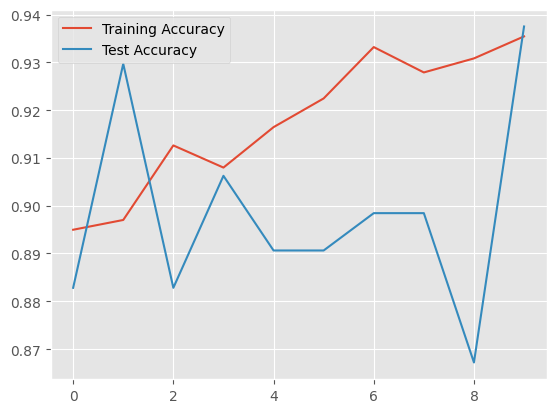

In [26]:
plt.style.use("ggplot")
plt.plot(train_acc, label="Training Accuracy")
plt.plot(test_acc, label="Test Accuracy")
plt.legend()

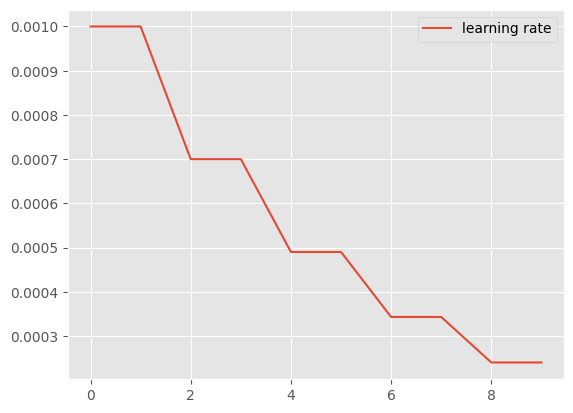

In [27]:
plt.plot(lrs, label = "learning rate")
plt.legend()

In [44]:
torch.save(model.state_dict(), "model.pth")           

# Checking with Kaggle Data

In [213]:
sample_submission = pd.read_csv("sample_submission.csv")

In [214]:
sample_submission.head(7)

,ImageId,Label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
5,6,0
6,7,0


In [215]:
test = pd.read_csv("test.csv")
test.head(5)
print(len(test))

28000


In [216]:
test_dataset=MNISTDataset(test, transform = torchvision.transforms.Compose([
                                torchvision.transforms.ToPILImage(),
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize(mean=0.5, std=0.5)]), is_test=True)


In [217]:
test_dataset[0][0].shape

torch.Size([1, 28, 28])

In [227]:
input_data = []
for x in range(len(test_dataset)):
    input_data.append(np.array(test_dataset[x][0].numpy()))

In [228]:
print("Number of values for testing are ", len(input_data))

Number of values for testing are  28000


In [229]:
input_data = torch.Tensor(input_data)
input_data.shape

torch.Size([28000, 1, 28, 28])

In [230]:
outputs = model(input_data)

In [231]:
outputs.shape

torch.Size([28000, 10])

In [260]:
col1 = []
col2 = []
for i in range(len(test_dataset)):
    col1.append(i+1)
col2 = outputs.argmax(axis=-1).detach().numpy()

In [263]:
sub = pd.DataFrame(list(zip(col1, col2)), 
                   columns=["ImageId", "Label"])
sub

,ImageId,Label
0,1,2
1,2,0
2,3,9
3,4,7
4,5,3
...,...,...
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9


In [265]:
sub.to_csv("submission.csv", index=False)